#### **NS2 Trace file Parser**

This python script parses through a NS2 nam `.tr` file.  
It searches for dropped packets made by user nodes, and calculates the percentage of dropped packets per second.  
A total degradation ratio is also displayed.  

We are simulating the maximum degradation rate of packets sent by users during a link-flooding DDoS attack.  
- Each link has a 4Mb bandwidth and a 5ms link delay, with a RED queueing strategy.
- Each bot sends traffic to the web server. The detection rate is 1 Mbps.
- Each user sends traffic a rate of 100 Kbps.
- All UDP traffic.

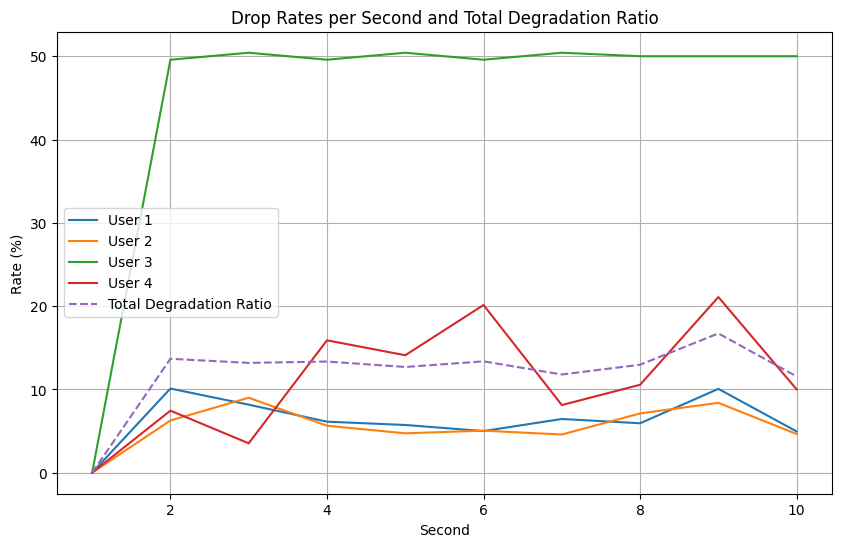

Total degradation ratio for User 1: 6.89%
Total degradation ratio for User 2: 6.12%
Total degradation ratio for User 3: 50.00%
Total degradation ratio for User 4: 12.08%
Total combined degradation ratio for all users: 13.23%


In [21]:
import math
import matplotlib.pyplot as plt

# Initialize dictionaries to store dropped packets and sent packets for each user node and each second
dropped_packets = {'0.0': {}, '1.0': {}, '2.0': {}, '3.0': {}}
sent_packets = {'0.0': {}, '1.0': {}, '2.0': {}, '3.0': {}}

# Open the trace file and process each line
with open('out.tr', 'r') as file:
    for line in file:
        # Extract elements from the line
        clean_trace = line.replace('------- ', '')
        elements = clean_trace.split()
        if len(elements) >= 11:  # Ensure the line contains enough elements
            node = elements[7]  # Source node
            time_sent = math.ceil(float(elements[1]))  # Time sent (rounded up to the nearest second)
            action = line[0]  # Action: 'd' for dropped, 'r' for received

            # Update counters for dropped packets and sent packets
            if node in dropped_packets:
                if action == 'd':
                    dropped_packets[node][time_sent] = dropped_packets[node].get(time_sent, 0) + 1
                elif action == 'r':
                    sent_packets[node][time_sent] = sent_packets[node].get(time_sent, 0) + 1

# Calculate drop rates per second for each user node
drop_rates = {}
for node in dropped_packets.keys():
    drop_rates[node] = []
    for second in range(1, max(max(dropped_packets[node], default=0), max(sent_packets[node], default=0)) + 1):
        dropped = dropped_packets[node].get(second, 0)
        sent = sent_packets[node].get(second, 0)
        drop_rate = (dropped / sent) * 100 if sent > 0 else 0  # Avoid division by zero
        drop_rates[node].append(drop_rate)

# Plot drop rates per second for each user node
plt.figure(figsize=(10, 6))
for node, rates in drop_rates.items():
    user_number = int(node.split('.')[0]) + 1
    plt.plot(range(1, len(rates) + 1), rates, label=f'User {user_number}')

# Calculate and plot the total degradation ratio over time
total_dropped = [sum(dropped_packets[node].get(second, 0) for node in dropped_packets.keys()) for second in range(1, max(max(dropped_packets[node], default=0), max(sent_packets[node], default=0)) + 1)]
total_sent = [sum(sent_packets[node].get(second, 0) for node in sent_packets.keys()) for second in range(1, max(max(dropped_packets[node], default=0), max(sent_packets[node], default=0)) + 1)]
total_degradation_ratio = [(total_dropped[i] / total_sent[i]) * 100 if total_sent[i] > 0 else 0 for i in range(len(total_dropped))]
plt.plot(range(1, len(total_degradation_ratio) + 1), total_degradation_ratio, label='Total Degradation Ratio', linestyle='--')

plt.xlabel('Second')
plt.ylabel('Rate (%)')
plt.title('Drop Rates per Second and Total Degradation Ratio')
plt.legend()
plt.grid(True)
plt.show()


#
### print more stats
#
# Print total degradation ratio percentages for each user
for node in dropped_packets.keys():
    total_dropped = sum(dropped_packets[node].values())
    total_sent = sum(sent_packets[node].values())
    degradation_ratio = (total_dropped / total_sent) * 100 if total_sent > 0 else 0
    user_number = int(node.split('.')[0]) + 1
    print(f'Total degradation ratio for User {user_number}: {degradation_ratio:.2f}%')
    
# Calculate total dropped and total sent packets for all users combined
total_dropped_combined = sum(sum(dropped_packets[node].values()) for node in dropped_packets.keys())
total_sent_combined = sum(sum(sent_packets[node].values()) for node in sent_packets.keys())

# Calculate total combined degradation ratio
total_degradation_ratio_combined = (total_dropped_combined / total_sent_combined) * 100 if total_sent_combined > 0 else 0

# Print total combined degradation ratio
print(f'Total combined degradation ratio for all users: {total_degradation_ratio_combined:.2f}%')

